<a href="https://colab.research.google.com/github/dlskawns/LG_Uplus_AI_Stage/blob/main/LG_Uplus_competition_NeuMF_keyword.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r "/content/drive/MyDrive/code/requirements.txt"

In [2]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [3]:
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

# 오리지날 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [4]:
history_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/buy_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/watch_e_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/search_data.csv'), encoding='utf-8')
metap_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data_plus.csv'), encoding='utf-8')

In [5]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.2

In [6]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [7]:
# 초기 데이터 처리
h_df = history_df[['profile_id','log_time','album_id']]
# meta = meta_df[['album_id','genre_mid','run_time']].drop_duplicates()
df = pd.merge(h_df, profile_df[['profile_id','sex','age']], 'left', on = 'profile_id')
df = pd.merge(df, meta_df, 'left', on = 'album_id')
view_cnts = df.groupby('profile_id')['album_id'].count()
df['views'] = df['profile_id'].map(lambda x: view_cnts[x])

In [8]:
search = search_df[['profile_id','album_id']].drop_duplicates()
search['search'] = 1

In [9]:
df = pd.merge(df,buy_df[['profile_id','album_id','payment']].drop_duplicates(), 'left', on = ['profile_id','album_id'])
df = pd.merge(df, search[['profile_id','album_id','search']], 'left', on=['profile_id','album_id'])
df.head(3)

,profile_id,log_time,album_id,sex,age,title,sub_title,genre_large,genre_mid,genre_small,...,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7,views,payment,search
0,3,20220301115719,15,F,5,거미,핑크퐁 3D율동동요,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN
1,3,20220301115809,16,F,5,상어 가족,노래율동,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN
2,3,20220301115809,16,F,5,상어 가족,핑크퐁 3D율동동요,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN


In [10]:
me = pd.merge(metap_df, meta_df[['album_id','title','genre_mid']] ,"left", on = "album_id").drop_duplicates()
me

,album_id,keyword_type,keyword_name,keyword_value,title,genre_mid
0,749,05010101,시리즈,0,어둠이 무서워요,TV만화
1,749,05010302,EBS,0,어둠이 무서워요,TV만화
2,749,05010401,3세,0,어둠이 무서워요,TV만화
3,749,05010402,4세,0,어둠이 무서워요,TV만화
4,749,05010407,1세,0,어둠이 무서워요,TV만화
...,...,...,...,...,...,...
832351,11629,05040104,신나는,0,손가락 하나,노래율동
832352,11629,0504010b,따라하고 싶은,0,손가락 하나,노래율동
832353,11629,05070e01,인체,0,손가락 하나,노래율동
832354,11629,05080401,캐릭터 친구들,0,손가락 하나,노래율동


In [11]:
import scipy.stats as stats

cross = np.array(pd.crosstab(me['keyword_name'],me['genre_mid']))
X = stats.chi2_contingency(cross,correction= False)
X2 = X[0]
p = X[1]
n = np.sum(cross)
mindim = min(cross.shape)-1
V = np.sqrt((X2/n)/mindim)
V

0.311367385290803

크래머 v 계수가 어느정도 상관성을 띈다.  
그러므로 가장 빈도가 높은 장르 5개에 대한 키워드 빈도가 다른지 한번 보자



In [91]:
me['genre_mid'].value_counts()[:5]

TV만화    232481
놀이교실    156211
노래율동    135862
외국어      85331
애니       38160
Name: genre_mid, dtype: int64

In [90]:
for i in me['genre_mid'].value_counts()[:5].index:
  print(me[me['genre_mid']==i]['keyword_name'].value_counts()[:5])

시리즈       9222
사회정서      8839
엔터        8561
스토리 애니    8290
언어1       7911
Name: keyword_name, dtype: int64
시리즈       10333
사회정서       8795
언어1        8713
엔터         7870
어린이 예능     6328
Name: keyword_name, dtype: int64
음악      6550
시리즈     5308
엔터      5159
노래      4958
음악예술    4626
Name: keyword_name, dtype: int64
동물        2562
영어유치원     2523
언어지능 1    1770
시간        1452
신체운동지능    1350
Name: keyword_name, dtype: int64
엔터        2057
시리즈       2041
사회정서      1940
스토리 애니    1874
언어1       1694
Name: keyword_name, dtype: int64


<BarContainer object of 13 artists>

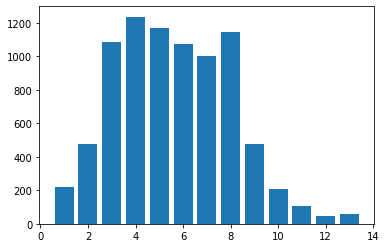

In [124]:
# 고객 연령 분포
plt.bar(df[['profile_id','age']].drop_duplicates()['age'].value_counts().index, df[['profile_id','age']].drop_duplicates()['age'].value_counts().values)

In [131]:
d = df[['profile_id','age','views']]
d = d[d['views']==1]

<BarContainer object of 13 artists>

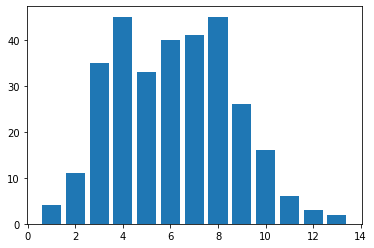

In [132]:
# view 1짜리 연령 분포
plt.bar(d['age'].value_counts().index, d['age'].value_counts().values)


<BarContainer object of 13 artists>

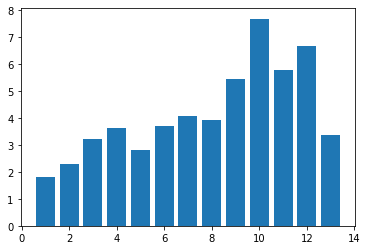

In [142]:
# 연령 별 view 1짜리 사람의 포션 파악 -> 이탈이 높은 연령대
d_values = d['age'].value_counts().sort_index() / df[['profile_id','age']].drop_duplicates()['age'].value_counts().sort_index() * 100
plt.bar(d_values.index, d_values.values)


view가 1인 경우:  
  해당 고객은 임베딩에서 제외,  
  해당 고객이 봤던 아이템 서칭  
  해당 아이템과 가장 유사한 아이템 체킹해서 추천  

In [11]:
df['payment'] = df['payment'].fillna(0)
df['payment'] = df['payment'].map(lambda x: 0 if x == 0 else 1)

In [12]:
data = df[['profile_id','log_time','album_id','views']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1
data.shape

(899252, 5)

In [13]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
# data = df[['profile_id','log_time','album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
# data['rating'] = 1
# data.shape

In [14]:
d = data[['profile_id','views']].drop_duplicates()
one_views_user = d[d['views']==1]['profile_id'].values

In [15]:
cfg.n_users = data.profile_id.max()+1#-len(one_views_user)
cfg.n_items = data.album_id.max()+1

In [16]:
data_new = data.drop(data[data['views']==1].index).reset_index()

In [17]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data_new, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719156, 6)
검증 데이터 크기: (179789, 6)


In [18]:
sparse.lil_matrix((cfg.n_users, cfg.n_items))

<33033x25917 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in List of Lists format>

In [19]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (idx, p, _, i, r, view) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/719156 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
# 유저 특징 정보 추출 
df = df.set_index('profile_id')
user_features = df[['age']].to_dict()
# # 성별, view, continuous 추가
df['sex'] = df['sex'].map(lambda x: 1 if x == 'M' else 0)
user_features_sex = df[['sex']].to_dict()
user_features_views = df[['views']].to_dict()
print("user_id 3의 age 정보 :", user_features['age'][3])
print("user_id 3의 age 정보 :", user_features_sex['sex'][3])
print("user_id 3의 age 정보 :", user_features_views['views'][3])

user_id 3의 age 정보 : 5
user_id 3의 age 정보 : 0
user_id 3의 age 정보 : 23


In [21]:
# 아이템 특징 정보 추출 
# meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
# meta['run_time']= meta['run_time'].map(lambda x: np.log10(x)+1)
item_features = meta_df[['genre_mid']].to_dict()
item_features_run = meta_df[['run_time']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])
print("album_id 749의 run_time 정보 :", item_features_run['run_time'][749])

album_id 749의 genre_mid 정보 : 5
album_id 749의 run_time 정보 : 539


In [22]:
# 검색 상호작용 딕셔너리 생성
search = search[search['album_id']<cfg.n_items]
search_dict = {}
for i in tqdm(search['profile_id'].unique()):
  search_dict[i] = list(search[search['profile_id']== i]['album_id'].values)

  0%|          | 0/644 [00:00<?, ?it/s]

In [23]:
# 구매 상호작용 딕셔너리 생성
buy = buy_df[['profile_id','album_id','payment']]
buy_dict = {}
for i in tqdm(buy['profile_id'].unique()):
  buy_dict[i] = list(buy[buy['profile_id']== i]['album_id'].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [24]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_sex = df['sex'].nunique()
cfg.n_search = 2
cfg.n_continuous_feats = 4 


## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [ ]:
df.columns

Index(['log_time', 'album_id', 'sex', 'age', 'genre_mid', 'run_time', 'views'], dtype='object')

In [25]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.n_sex = cfg.n_sex
        self.n_search = cfg.n_search
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        # mf용 유저임베딩 - 유저 임베딩 수 == 유저 cfg 수, 임베딩 차원 수 == 256 
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        # mlp 용 유저 임베딩, 차원 수도 동일한 방법
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        # mlp 용 특성 장르 임베딩도 설정
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        # mlp 용 특성 성별 임베딩도 설정
        self.sex_embeddig = nn.Embedding(num_embeddings=self.n_sex, embedding_dim=self.n_sex//2)
        # mlp 용 특성 search 임베딩 설정
        self.search_embedding = nn.Embedding(num_embeddings=self.n_search, embedding_dim=self.n_search//2)
        
        # mlp 레이어 - 시퀜셜 모델로 생성
        self.mlp_layers = nn.Sequential(
            # 첫번째 인자값은 input size, 두번째 인자값은 output size이다
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_sex//2 + self.n_search//2 + self.n_continuous_feats, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        # 임베딩 진행
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_embedding_mlp = self.genre_embeddig(feats[3])

        
        #성별 임베딩 추가
        sex_embedding_mlp = self.sex_embeddig(feats[2])

        #검색여부 임베딩 추가
        search_embedding_mlp = self.search_embedding(feats[5])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, sex_embedding_mlp, search_embedding_mlp, feats[0].unsqueeze(1), feats[1].unsqueeze(1),feats[4].unsqueeze(1), feats[6].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [73]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        if user_id in 
        UIdataset[user_id] = []
        # positive 샘플 계산 
        # pos item은 0.5 이상인 것들의 index를 찾아 출력
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        # pos 샘플 개수
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling)
        # neg 샘플 개수 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        # neg 샘플 중 랜덤 초이스
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        # pos, neg 샘플 짝지어서 UIdataset에 넣기
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 추출 
        features_age = []
        features_views = []
        features_sex = []

        # pos, neg 쌍을 하나씩 뽑고,
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            # user_features의 user에 따른 나이를 features에 넣기
            features_age.append(user_features['age'][user_id])  # float
            features_views.append(user_features_views['views'][user_id])  # float
            features_sex.append(user_features_sex['sex'][user_id])  # long
        #나이 정보 순서를 append해서 모든 쌍에 추가해주기
        UIdataset[user_id].append(np.array(features_age))
        UIdataset[user_id].append(np.array(features_views))
        UIdataset[user_id].append(np.array(features_sex))

        features_genre = []
        features_run = []
        features_search = []
        features_payment = []
        # pos와 neg 일렬 리스트로 변환
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            # item_features의 item에 따른 장르를 features에 넣기
            features_genre.append(item_features['genre_mid'][item_id])  # long
            features_run.append(item_features_run['run_time'][item_id]) # float

            if user_id in search_dict.keys():
              if item_id in search_dict[user_id]:
                features_search.append(1)
              else:
                features_search.append(0)
            else:
              features_search.append(0)
            if user_id in buy_dict.keys():
              if item_id in buy_dict[user_id]:
                features_payment.append(int(buy[(buy['profile_id']==user_id)&(buy['album_id']==item_id)]['payment'].values[0]))
              else:
                features_payment.append(0)
            else: 
              features_payment.append(0)
        #장르 정보를 append해서 모든 쌍에 추가해주기 -> 상호작용에 feature가 추가된것임
        UIdataset[user_id].append(np.array(features_genre))
        UIdataset[user_id].append(np.array(features_run))
        UIdataset[user_id].append(np.array(features_search))
        UIdataset[user_id].append(np.array(features_payment))

        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

SyntaxError: ignored

In [24]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [ ]:
UIdataset[3]

[array([   16,    17,    18, ...,  7343,  8615, 22028]),
 array([5, 5, 5, ..., 5, 5, 5]),
 array([23, 23, 23, ..., 23, 23, 23]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 1,  1,  1, ..., 10,  5, 17]),
 array([ 660,  660,  660, ...,  731,  463, 1004]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1., 1., 1., ..., 0., 0., 0.])]

In [25]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []  # age
    batch_feat1 = []  # views
    batch_feat2 = []  # sex 
    batch_feat3 = []  # genre
    batch_feat4 = []  # runtime
    batch_feat5 = []  # runtime
    batch_feat6 = []  # runtime
    batch_labels = [] # label
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        feat2 = UIdataset[user_id][3]
        feat3 = UIdataset[user_id][4]
        feat4 = UIdataset[user_id][5]
        feat5 = UIdataset[user_id][6]
        feat6 = UIdataset[user_id][7]                
        labels = UIdataset[user_id][8]
        user_ids = np.full(len(item_ids), user_id)  # 모든 값을 user_id로 통일
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())      
        batch_feat5.extend(feat5.tolist())   
        batch_feat6.extend(feat6.tolist())   
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, batch_feat3, batch_feat4,batch_feat5, batch_feat6, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [221]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    user_indices = np.delete(user_indices, one_views_user)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    

    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1,feat2, feat3, feat4,feat5, feat6, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.FloatTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device)
        feat3 = torch.LongTensor(feat3).to(cfg.device)
        feat4 = torch.FloatTensor(feat4).to(cfg.device)
        feat5 = torch.LongTensor(feat5).to(cfg.device)
        feat6 = torch.FloatTensor(feat6).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [222]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [ ]:
query_user_ids = df.reset_index()['profile_id'].unique()

In [ ]:
full_item_ids = np.array([c for c in range(cfg.n_items)])
full_item_ids_feat3 = [item_features['genre_mid'][c] for c in full_item_ids]
full_item_ids_feat4 = [item_features_run['run_time'][c] for c in full_item_ids]

In [ ]:
f = np.zeros(10)
np.put(f, [6,2,1,0], [1,2,6,7, 7])

In [ ]:
buy_dict[1603]

[1640]

In [ ]:
buy_dict[user_id][0]

3767

In [ ]:
buy[(buy['profile_id']==user_id)&(buy['album_id']==buy_dict[user_id])]

In [ ]:

for user_id in data['profile_id'].unique():
  print(user_id)
  f = np.zeros(cfg.n_items)
  if user_id in search_dict.keys():
    print(len(f), search_dict[user_id])
    np.put(f, search_dict[user_id], 1)
  if user_id ==17128:
    break

In [41]:
one_views_dict = {}
for user_i, _,album_i,_,_ in np.array(data[data['views']==1]):
  one_views_dict[user_i] = album_i


In [255]:
metap_df.head(3)

,album_id,keyword_type,keyword_name,keyword_value,label
0,749,05010101,시리즈,0,1
1,749,05010302,EBS,0,1
2,749,05010401,3세,0,1


In [43]:
meta = pd.merge(metap_df[['album_id','keyword_type','keyword_value']].drop_duplicates(), meta_df.drop(columns = ['sub_title', 'genre_small','onair_date','genre_large','cast_2','cast_3','cast_4','cast_5','cast_6','cast_7']).drop_duplicates(), "left", on='album_id')
meta.shape

(767948, 8)

In [44]:
meta[meta['keyword_value']==5]

,album_id,keyword_type,keyword_value,title,genre_mid,country,run_time,cast_1
7,749,05020201,5,어둠이 무서워요,1,한국,660,타요
11,749,0508042c,5,어둠이 무서워요,1,한국,660,타요
14,749,0508050a,5,어둠이 무서워요,1,한국,660,타요
28,750,05020201,5,우리는 친구,1,한국,660,타요
34,750,0508042c,5,우리는 친구,1,한국,660,타요
...,...,...,...,...,...,...,...,...
767917,39874,05030702,5,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,5,한국,466,NaN
767928,4779,05020204,5,손가락을 빨게 돼요,23,한국,293,NaN
767929,4779,05030604,5,손가락을 빨게 돼요,23,한국,293,NaN
767938,11629,05020205,5,손가락 하나,4,한국,91,타요와 친구들


In [40]:
metap_df[metap_df['keyword_value']==5].groupby('album_id')

38722

In [47]:
5 in meta[meta['album_id']==0]['keyword_value'].values

True

In [63]:
lst = [] 
lst_example1  = [222,555,777]
lst_example2  = [33,44,99]
for i in range(10):
  if i==1:
    lst.append(lst_example1)
  if i==2:
    lst + lst_example2
lst

[[222, 555, 777]]

In [ ]:
keywords = []
for i in tqdm(meta['album_id'].unique()):
  m = meta[meta['album_id']==i]['keyword_value'].values

  cnt = 0
  key_val = 5
  while cnt < 5: 
    if key_val in m:
      if len(m5[m5['album_id']==i]['keyword_type'].value) >5:
        keywords.extend(m5[m5['album_id']==i]['keyword_type'].values[:4])
        cnt == 5
      else:
        keywords.extend(m5[m5['album_id']==i]['keyword_type'].values)
        cnt += len(m5[m5['album_id']==i]['keyword_type'].values)
        if 5- n > 0:
          if 4 in m:
            if len(m4[m4['album_id']==i]['keyword_type'].values) > n:
              keyword

In [54]:
keywords = []
m5 = meta[meta['keyword_value']==5]
m4 = meta[meta['keyword_value']==4]
m3 = meta[meta['keyword_value']==3]
m2 = meta[meta['keyword_value']==2]
m1 = meta[meta['keyword_value']==1]
m0 = meta[meta['keyword_value']==0]
for i in tqdm(meta['album_id'].unique()):
  m = meta[meta['album_id']==i]['keyword_value'].values
  if 5 in m:
    if len(m5[m5['album_id']==i]['keyword_type'].value) >5:
      keywords.append(m5[m5['album_id']==i]['keyword_type'].values[:4])
    else:
      keywords.append(m5[m5['album_id']==i]['keyword_type'].values)
      n = len(m5[m5['album_id']==i]['keyword_type'].values)
      if 5- n > 0:
        if 4 in m:
          if len(m4[m4['album_id']==i]['keyword_type'].values) > n:
            keywords.append(m4[m4['album_id']==i]['keyword_type'].values[:n-1])
        else:
          keywords.append(m4[m4['album_id']==i]['keyword_type'].values)
        if 0 in m:
          if len(m4[m4['album_id']==i]['keyword_type'].values) > n:
            keywords.append(m4[m4['album_id']==i]['keyword_type'].values[:n-1])
          else:
            keywords.append(m4[m4['album_id']==i]['keyword_type'].values)
  if 4 in m:
    keywords.append(m4[m4['album_id']==i]['keyword_type'].values)
  elif 3 in m:
    keywords.append(m3[m3['album_id']==i]['keyword_type'].values)
  elif 2 in m:
    keywords.append(m2[m2['album_id']==i]['keyword_type'].values)
  elif 1 in m:
    keywords.append(m1[m1['album_id']==i]['keyword_type'].values)    
  elif 0 in m:
    keywords.append(m0[m0['album_id']==i]['keyword_type'].values) 
meta_new = meta.drop(columns = ['keyword_type', 'keyword_value']).drop_duplicates()
meta_new['keywords'] = keywords


In [66]:
meta[meta['keyword_value']==5].groupby('album_id')['keyword_type'].count().value_counts()

2     12210
1     11882
3      6434
4      3168
5      2242
6       826
7       489
8       389
9       301
10      192
11      157
12      112
13       78
14       54
15       35
16       23
30       22
17       15
19       11
18        9
22        8
24        7
21        6
20        6
23        6
31        6
29        5
56        5
28        3
25        3
57        2
38        2
37        2
41        2
27        2
55        1
60        1
33        1
26        1
45        1
35        1
39        1
32        1
Name: keyword_type, dtype: int64

In [60]:
meta_new['keywords'].map(lambda x: len(x)).value_counts()

2     12459
1     11925
3      6514
4      3214
5      2362
6       858
7       512
8       406
9       327
10      215
11      193
12      152
13      130
14      112
15       98
16       89
17       61
18       54
19       39
20       28
30       23
22       15
21       14
24       10
23        8
56        7
31        6
29        5
25        5
27        3
57        3
37        3
28        3
26        2
45        2
33        2
38        2
32        2
41        2
35        2
44        1
40        1
49        1
59        1
50        1
60        1
55        1
39        1
Name: keywords, dtype: int64

In [37]:
meta.groupby('album_id')['keyword_name'].count().sort_values().value_counts().sort_index()

1      21
2     229
3      47
4      26
5     135
     ... 
84      1
87      1
89      2
91      1
94      2
Name: keyword_name, Length: 87, dtype: int64

키워드 5개까지의 album_id는 제외하고 정리한다.

In [28]:
meta_keyword_cnt = pd.DataFrame(meta.groupby('album_id')['keyword_name'].count()).reset_index()
meta_under_five_idx = meta_keyword_cnt[meta_keyword_cnt['keyword_name']<=5]['keyword_name'].index

In [49]:
meta_new

,album_id,title,genre_mid,country,run_time,cast_1,keywords
0,749,어둠이 무서워요,1,한국,660,타요,"[시리즈, EBS, 3세, 4세, 1세, 2세, TV 방영, 스토리 애니, 엔터, ..."
21,750,우리는 친구,1,한국,660,타요,"[시리즈, EBS, 3세, 4세, 1세, 2세, TV 방영, 스토리 애니, 엔터, ..."
42,2131,타요의 첫 운행,1,한국,660,타요,"[시리즈, EBS, 3세, 4세, 1세, 2세, TV 방영, 스토리 애니, 엔터, ..."
65,2625,길 잃은 타요,1,한국,660,타요,"[시리즈, EBS, 3세, 4세, 1세, 2세, TV 방영, 스토리 애니, 엔터, ..."
85,2594,새내기 꼬마 버스의 하루,1,한국,660,타요,"[시리즈, EBS, 3세, 4세, 1세, 2세, TV 방영, 스토리 애니, 엔터, ..."
...,...,...,...,...,...,...,...
760053,39872,로티프렌즈와 색칠놀이! - 캔디코 ＆ 동화책,5,한국,443,NaN,"[시리즈, 2분 이상 10분 미만, 엔터, 미술, 그림그리기/색칠하기, 언어1, 운동]"
760060,39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,5,한국,477,NaN,"[시리즈, 2분 이상 10분 미만, 엔터, 미술, 그림그리기/색칠하기, 언어1, 운동]"
760067,39874,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,5,한국,466,NaN,"[시리즈, 2분 이상 10분 미만, 엔터, 미술, 그림그리기/색칠하기, 언어1, 운동]"
760074,4779,손가락을 빨게 돼요,23,한국,293,NaN,"[단편, 책TV, 2분 이상 10분 미만, 4세, 5세, 6세, 7세, 엔터, 동화..."


In [50]:
' '.join(['시리즈','EBS','3세'])

'시리즈 EBS 3세'

In [54]:
meta_new['keywords'].map(lambda x: ' '.join(x))

0         시리즈 EBS 3세 4세 1세 2세 TV 방영 스토리 애니 엔터 친구 캐릭터 친구들...
21        시리즈 EBS 3세 4세 1세 2세 TV 방영 스토리 애니 엔터 친구 도움 산만함 ...
42        시리즈 EBS 3세 4세 1세 2세 TV 방영 스토리 애니 엔터 친구 격려 캐릭터 ...
65        시리즈 EBS 3세 4세 1세 2세 TV 방영 스토리 애니 엔터 친구 미아방지 캐릭...
85        시리즈 EBS 3세 4세 1세 2세 TV 방영 스토리 애니 엔터 친구 교통안전 캐릭...
                                ...                        
760053             시리즈 2분 이상 10분 미만 엔터 미술 그림그리기/색칠하기 언어1 운동
760060             시리즈 2분 이상 10분 미만 엔터 미술 그림그리기/색칠하기 언어1 운동
760067             시리즈 2분 이상 10분 미만 엔터 미술 그림그리기/색칠하기 언어1 운동
760074    단편 책TV 2분 이상 10분 미만 4세 5세 6세 7세 엔터 동화 창작동화 감정그...
760089    시리즈 2분 미만 엔터 노래 율동 음악 동요 노래 따라하기 신나는 따라하고 싶은 인...
Name: keywords, Length: 39875, dtype: object

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## 단어 빈도에 따른 벡터화 - CountVectorizer도 활용 가능합니다.
cnt = CountVectorizer(min_df=1, ngram_range = (1,1))
df_cnt = cnt.fit_transform(meta_new['keywords'].map(lambda x: ' '.join(x)))
a = pd.DataFrame(df_cnt.todense(), columns = cnt.get_feature_names())
# pd.DataFrame(cosine_similarity(df_cnt, df_cnt))
a
# 단어 빈도에 따른 벡터화 - TfidfVectorizer
# tfidf = TfidfVectorizer()
# df_tfidf = tfidf.fit_transform(df['features'])
# df_tfidf = pd.DataFrame(df_tfidf.todense(), columns = tfidf.get_feature_names())

# Tfidf 후의 각 샘플(영화) 별 vector


,10분,18분,1세,1차,2분,2세,2차,3세,4세,5세,...,환경과,환상,환영하기,활동,황사,회화,효도,휴대폰,흥미진진한,희망
0,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39870,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39871,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39872,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39873,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
meta = meta.drop(columns = 'keyword_name').drop_duplicates()
meta['keyword'] = 0
for i in meta['album_id'].unique():
    meta['keyword'] = keywords[i]

ValueError: ignored

In [ ]:
keywords

In [ ]:
one_views_dict

In [ ]:
item_lookup = df

In [28]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    # full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    full_item_ids_feat3 = [item_features['genre_mid'][c] for c in full_item_ids]
    full_item_ids_feat4 = [item_features_run['run_time'][c] for c in full_item_ids]
    for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
            if user_id in one_views_user:
              

            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = np.full(cfg.n_items, user_features_views['views'][user_id])
            feat1 = torch.FloatTensor(feat1).to(cfg.device)
            feat2 = np.full(cfg.n_items, user_features_sex['sex'][user_id])
            feat2 = torch.LongTensor(feat2).to(cfg.device)
            feat3 = torch.LongTensor(full_item_ids_feat3).to(cfg.device)
            feat4 = torch.FloatTensor(full_item_ids_feat4).to(cfg.device)
            # detach로 validation set에 대한 그래프 history 차단 후 inference
            feat5 = np.zeros(cfg.n_items)
            if user_id in search_dict.keys():
              np.put(feat5, search_dict[user_id], 1)
            feat5 = torch.LongTensor(feat5).to(cfg.device)           
            feat6 = np.zeros(cfg.n_items)
            if user_id in buy_dict.keys():
              np.put(feat6, buy_dict[user_id], buy[(buy['profile_id']==user_id)&(buy['album_id']==buy_dict[user_id][0])]['payment'].values[0])
            feat6 = torch.FloatTensor(feat6).to(cfg.device)
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        

        pred_u_idx = np.argsort(pred_u_score)[::-1]         # 최종 스코어 높은 순서대로 인덱스 뽑기

        pred_u = full_item_ids[pred_u_idx]                  # 전체 아이템 중에서 스코어가 높은 인덱스들 뽑아 리스트 가져오기

        pred_list.append(list(pred_u[:cfg.top_k]))          # top_k개 만큼을 pred_list에 넣기

    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [36]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 10
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [30]:
# model 생성 및 optimizer, loss 함수 설정 
model2 = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model2.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [ ]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model2, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model2, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model2.state_dict(), os.path.join('/content/drive/MyDrive/code/saved', 'model2(best_scores).pth'))

In [ ]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model2, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model2, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model2.state_dict(), os.path.join('/content/drive/MyDrive/code/saved', 'model2(best_scores).pth'))

### 학습 과정 시각화

In [37]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

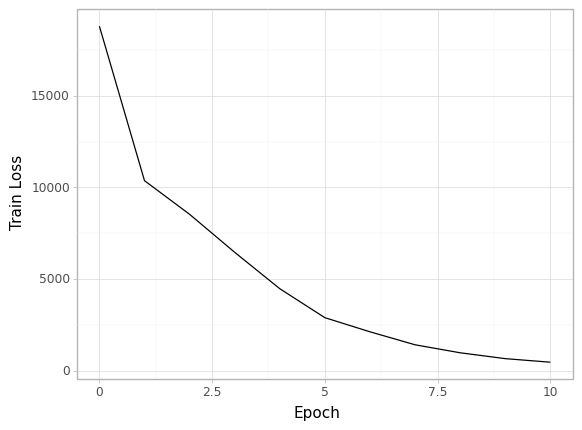

<ggplot: (8758663100657)>

In [38]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))+ geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [39]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

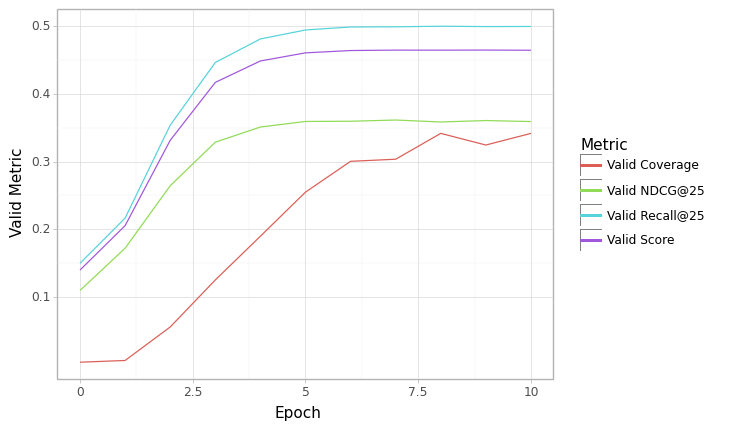

<ggplot: (8758671463925)>

In [40]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [41]:
model2.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/code/saved', 'model2(best_scores).pth')))

<All keys matched successfully>

In [42]:
submission_path = os.path.join('/content/drive/MyDrive/data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model2, submission, mode='test')

### 저장

In [43]:
submission.to_csv(os.path.join('/content/drive/MyDrive/data', 'submission2_changed.csv'), index = False)

In [ ]:
valid.shape

(179851, 4)

In [ ]:
df.columns

Index(['log_time', 'album_id', 'sex', 'age', 'title', 'sub_title',
       'genre_large', 'genre_mid', 'genre_small', 'country', 'run_time',
       'onair_date', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'cast_6', 'cast_7', 'views'],
      dtype='object')

In [ ]:
valid_df = pd.merge(valid, df[['profile_id','views']], "left", on = 'profile_id')
valid_df.shape

In [ ]:
val_pred = valid_epoch(cfg, model, valid)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classification_report(val_pred)